In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)



validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(trainloader))
print(len(validloader))

# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)  
# If 'mps or cuda:0' is printed, it means GPU is available.

Files already downloaded and verified
Files already downloaded and verified
12500
2500
mps


In [7]:
class ShortConn2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=1, stride=stride, padding=0)
            
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

In [8]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                             kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # skip connect projection from in_channels to out_channels
        # depending on the stride and channels to do a projection
        # or just pass on the input
        if stride == 1 and in_channels == out_channels:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = ShortConn2d(in_channels, out_channels, stride)
        
    def forward(self, x):
        # reserve this now for the skip connection
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)

        # not applying activation here for densenet implementation
        return x + shortcut

        
        

In [9]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        ### RES 1
        
        # 3x32x32 to 10x32x32
        self.rb1 = ResBlock(3, 10, 1)
        self.act1 = nn.ReLU()

        ### RES 2

        # 10x32x32 to 20x32x32
        self.rb2 = ResBlock(10, 20, 1)
        # RES 1 skip connection 3x32x32 to 20x32x32
        self.sc1 = ShortConn2d(3, 20, 1)  
        self.act2 = nn.ReLU()
        
        ### RES 3
        
        # 20x32x32 to 20x16x16
        self.rb3 = ResBlock(20, 20, 2)
        # RES 1 skip connection for 3x32x32 to 20x16x16
        self.sc2 = ShortConn2d(3, 20, 2)
        # RES 2 skip connection 10x32x32 to 20x16x16
        self.sc3 = ShortConn2d(10, 20, 2)
        self.act3 = nn.ReLU()  
        
        # input image shape = 20x4x4
        # affine operation to hidden layer with 100 neurons
        self.fc1 = nn.Linear(20 * 16 * 16, 100)
        self.bn4 = nn.BatchNorm1d(100)
        self.act4 = nn.ReLU()
        
        # affine operation to output layer with 10 neurons
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
       
        res1_sc1 = self.sc1(x)
        res1_sc2 = self.sc2(x)
        x = self.rb1(x)
        x = self.act1(x)
        
        res2_sc1 = self.sc3(x)
        x = self.rb2(x)
        x = self.act2(x + res1_sc1)
        
        x = self.rb3(x)
        x = self.act3(x + res1_sc2 + res2_sc1)
        
        # flatten and pass through fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.act4(x)
        x = self.fc2(x)
        return x
    

In [29]:
PATH = './cifar_dense_exp_adam.pth'

epochs = 20             # Total epochs.
iter_n = len(trainloader)  # number of iteration per epoch
record_freq = iter_n // 100  # Record frequency.
print_freq = iter_n // 100 # Print frequency, need to be multiple of record_freq.

# a number for computing running validation loss in each iteration.
train_per_valid = len(trainloader) / len(validloader)  

avg_train_losses, avg_valid_losses = [], []   # Avg. losses.
train_accuracies, valid_accuracies = [], []  # Train and test accuracies.

dense_net = DenseNet()     # Create the network instance.
dense_net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  

# We use Adam as optimizer.
opt = optim.Adam(dense_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# add plateau scheduling
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.7)

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_train_loss = 0.0       # Initialize running train_loss for training set.
    running_val_loss = 0.0     # Initialize running train_loss for validation set.
    
    # Initialize running total and correct for computing train accuracy.
    train_correct = 0 
    train_total = 0
    # Initialize running total and correct for computing test accuracy.
    valid_total = 0   
    valid_correct = 0
    
    print('--> [Start of epoch {}]'.format(epoch) +
          '  lr: {:.6f}'.format(scheduler.get_last_lr()[0]))
    
    
    validiter = iter(validloader)
    for i, data in enumerate(iterable=trainloader, start=0):
        
        # Set the model to training mode.
        dense_net.train()
        
        # Get the train_inputs.
        train_inputs, train_labels = data
        
        # Move the train_inputs to the specified device.
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step
        train_output = dense_net(train_inputs)
        train_loss = loss_func(train_output, train_labels)
        
        # Backward step.
        train_loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        
        dense_net.eval()
        # record statistics.
        running_train_loss += train_loss.item()
        
        # only iterate through validation set according to train_per_valid ratio
        if i % train_per_valid == train_per_valid - 1:
            # Set the model to evaluation mode.
            with torch.no_grad():
                valid_inputs, valid_labels = next(validiter)
                valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
                valid_output = dense_net(valid_inputs)
                valid_loss = loss_func(valid_output, valid_labels)
                running_val_loss += valid_loss.item()
                
                _, valid_predicted = torch.max(valid_output.data, 1)
                valid_total += valid_labels.size(0)
                valid_correct += (valid_predicted == valid_labels).sum().item()
        
        # record training accuracy in every mini-batch
        _, train_predicted = torch.max(train_output.data, 1)
        train_total += train_labels.size(0)
        train_correct += (train_predicted == train_labels).sum().item()
        
        # Record training/validation loss every several mini-batches.
        if i % record_freq == record_freq - 1: 
            avg_train_loss = running_train_loss / record_freq
            avg_train_losses.append(avg_train_loss)
            avg_valid_loss = train_per_valid * running_val_loss / record_freq
            avg_valid_losses.append(avg_valid_loss)
            running_train_loss, running_val_loss = 0.0, 0.0
            
            # only print traing training loss once in a while to avoid cluster output
            if i % print_freq == print_freq - 1:
                print('[epoch: {}, i: {:5d}]'.format(epoch, i) +
                      '  train_loss: {:.3f}'.format(avg_train_loss) + 
                      '  |  valid_loss: {:.3f}'.format(avg_valid_loss))

    # do exponential scheduling
    scheduler.step()
                   
    # calculating train accuracy
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    valid_accuracy = 100 * valid_correct / valid_total
    valid_accuracies.append(valid_accuracy)

    # Store the networks after each epochs.
    # in case we want to do simple average or weighted average
    torch.save({
            'epoch': epoch,
            'model_state_dict': dense_net.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': avg_train_losses[epoch],
            'train_accuracy': train_accuracies[epoch],
            'valid_accuracy': valid_accuracies[epoch],
            }, PATH)
    
    print('--> [End of epoch {}]'.format(epoch) +
                      ' train_accuracy: {:.2f}%'.format(train_accuracy) + 
                      '  |  valid_accuracy: {:.32}%'.format(valid_accuracy))
              

print('Finished Training.')

--> [Start of epoch 10]  lr: 0.000028
[epoch: 10, i:   124]  train_loss: 0.801  |  valid_loss: 0.678
[epoch: 10, i:   249]  train_loss: 0.750  |  valid_loss: 0.782
[epoch: 10, i:   374]  train_loss: 0.738  |  valid_loss: 0.781
[epoch: 10, i:   499]  train_loss: 0.770  |  valid_loss: 0.749
[epoch: 10, i:   624]  train_loss: 0.863  |  valid_loss: 0.858
[epoch: 10, i:   749]  train_loss: 0.777  |  valid_loss: 0.567
[epoch: 10, i:   874]  train_loss: 0.729  |  valid_loss: 0.689
[epoch: 10, i:   999]  train_loss: 0.787  |  valid_loss: 0.718
[epoch: 10, i:  1124]  train_loss: 0.738  |  valid_loss: 0.840
[epoch: 10, i:  1249]  train_loss: 0.805  |  valid_loss: 0.649
[epoch: 10, i:  1374]  train_loss: 0.824  |  valid_loss: 0.647
[epoch: 10, i:  1499]  train_loss: 0.791  |  valid_loss: 0.874
[epoch: 10, i:  1624]  train_loss: 0.788  |  valid_loss: 0.693
[epoch: 10, i:  1749]  train_loss: 0.752  |  valid_loss: 0.724
[epoch: 10, i:  1874]  train_loss: 0.810  |  valid_loss: 0.696
[epoch: 10, i:  1

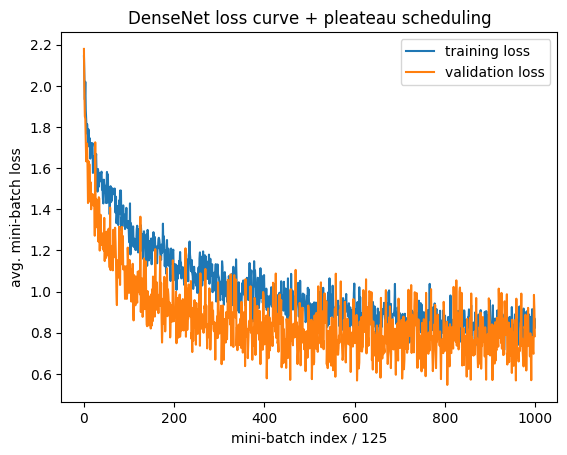

In [28]:
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.title('DenseNet loss curve + pleateau scheduling')
plt.xlabel('mini-batch index / {}'.format(record_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

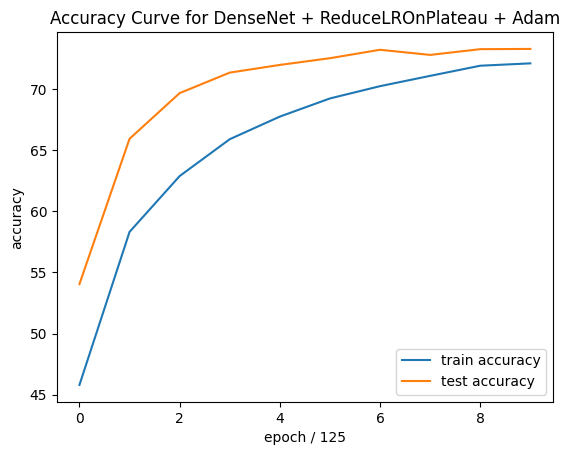

In [21]:
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.title('Accuracy Curve for DenseNet + ReduceLROnPlateau + Adam')
plt.xlabel('epoch / {}'.format(record_freq))
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

In [23]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

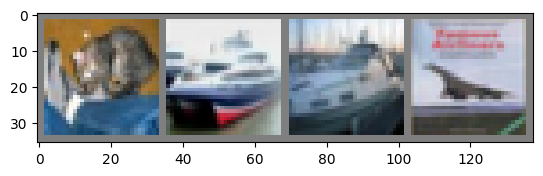

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [24]:
# Check several images.
dataiter = iter(validloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = dense_net(images.to(device))

# max compare along the row, return the index of the max value, which is the predicted class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [25]:
dense_net.eval()
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = dense_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73.13 %


In [26]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = dense_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 70 %
Accuracy of   car : 84 %
Accuracy of  bird : 59 %
Accuracy of   cat : 48 %
Accuracy of  deer : 69 %
Accuracy of   dog : 65 %
Accuracy of  frog : 84 %
Accuracy of horse : 74 %
Accuracy of  ship : 91 %
Accuracy of truck : 83 %
